Investigate the glacier-scale and regional-scale trend in water area over time

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# open subregions from kaab/shean
path_r = os.path.join(folder_HMA, 'Datasets', "AOI definition", "Final AOI", 'Final Products', "subregions.shp")
subregion_gdf = gpd.read_file(path_r).to_crs("ESRI:102025").sort_values('fid')

# add the subregion as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(subregion_gdf[["region","geometry"]])
dc_gdf = dc_gdf.sjoin(subregion_gdf[["region","geometry"]])

In [4]:
# add color column to new subregion gdf
colors = plt.cm.Spectral(np.linspace(0, 1, len(subregion_gdf)))
subregion_gdf['colors']=list(colors)

In [5]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [6]:
# open the water data for each glacier, format into a single df
c=0
all_series = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>10: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific cloud info as a pd.Series, append to list   
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_binary_otsuoptimal_188_binned4_accaqa.csv')
    # path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'annual_water_area_binary_otsuoptimal_1318_binned4_accaqa.csv')
    
    df_g = pd.read_csv(path_open, index_col=0, header=None).squeeze()
    df_g['region'] = str(o3region)#.zfill(2)
    all_series.append(df_g)

# format into df
df_all = pd.DataFrame(all_series).reset_index(drop=True)

# format to numeric dtypes
all_cols = df_all.columns
for c in all_cols:
    if c in ['rgi_id', 'o1_region', 'o2_region', 'region']: continue
    df_all[c] = df_all[c].astype(float)

# add extra columns on for each glacier (dc area, etc...)
df_all = df_all.merge(dc_gdf[['rgi_id','area_dc']], on='rgi_id')

# merge with glacier area
print("All done!")

df_big = df_all[df_all['area_dc']>5]

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-30998
300 of 769 RGI2000-v7.0-G-14-11049
400 of 769 RGI2000-v7.0-G-14-29167
500 of 769 RGI2000-v7.0-G-15-00573
600 of 769 RGI2000-v7.0-G-15-04349
700 of 769 RGI2000-v7.0-G-15-08020
All done!


In [7]:
# load in the list of lake-terminating glaciers, so we can remove those if we want
path_open = os.path.join(folder_datasets, 'lake-terminating glaciers', 'rgi_lake_terminating.csv')
df_lake_term = pd.read_csv(path_open)
rgi_lake_term = df_lake_term['rgi_id'].values
# rgi_lake_term

In [8]:
# create subsets of lake terminating vs non-lake terminating so we can compare
df_all_lt = df_all[df_all['rgi_id'].isin(rgi_lake_term)]
df_all_nlt = df_all[~df_all['rgi_id'].isin(rgi_lake_term)]

In [9]:
# select which df to use from here
df_to_use = df_all_nlt #df_all df_all_nlt

In [34]:
# define annual columns, 5-year columns
# intervals = [ [1990,1994],[1995,1999],[2000,2004],[2005,2009],[2010,2014],[2015,2019],[2020,2023] ]
ys = [1988,1992,1994,1996,1998,2000,2002,2004] + list(range(2005,2024))
mids = [1989.5,1992.5,1994.5,1996.5,1998.5,2000.5,2002.5,2004] + list(range(2005,2024))
c_1yr = [ f"water_{y}_m2" for y in ys ]

In [35]:
# function to darken/lighten a given color
# https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [36]:
# plot annual timeseries of a single glacier ( provide either glacier name or rgi_id)
def plot_single_glacier(rgi_id, glacier_name):

    # get the rgi_id if glacier name was provided
    if glacier_name: rgi_id = rgi_gdf[rgi_gdf['glac_name'].str.contains(glacier_name)==True]['rgi_id'].values[0]
    g_df = df_all[df_all['rgi_id']==rgi_id]
    glacier_name = rgi_gdf[rgi_gdf['rgi_id']==rgi_id]['glac_name'].values[0]

    # formatting of data
    c_1yr_term = [ f"water_{y}_terminus_m2" for y in ys ]
    areas_all = g_df[c_1yr].values[0]/10000
    areas_terminus = g_df[c_1yr_term].values[0]/10000
    ymax = np.nanmax(areas_all)*1.1
    dc_area = g_df['area_dc'].values[0]#*(1000*1000)/10000 /100

    # initiate figure
    fig,axs = plt.subplots(figsize=(8,4))
    ax2 = axs.twinx() # twin axis for showing percentage

    # plot the data
    axs.plot( mids, areas_all, label='Entire Glacier')
    axs.plot( mids, areas_terminus, label='Lower Half Only')
    ax2.plot(mids, areas_all/dc_area)

    axs.grid(zorder=1, linestyle='dashed')
    axs.set_xlabel("Year")
    axs.set_ylabel("SGL Area (x10000 m2)")
    ax2.set_ylabel("SGL Area (%)")

    # override ymax if you want
    # ymax=22
    axs.set_ylim(0,ymax)
    ax2.set_ylim(0,ymax/dc_area)

    axs.legend()
    axs.set_title(f"Name: {glacier_name}\nRGI_ID: {rgi_id}")
    plt.tight_layout()

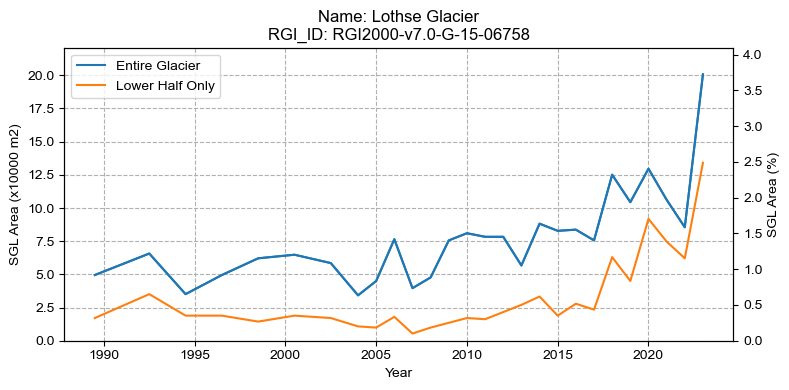

In [37]:
rgi_id = 'RGI2000-v7.0-G-15-09532' # choose which you want to provide
glacier_name = 'Loth'
plot_single_glacier(rgi_id, glacier_name)

In [55]:
# sneaky save csv holding entire region's timeseries so we can use in other plots
sgl_areas_nlt = df_all_nlt[c_1yr].sum(axis=0).values
sgl_areas_all = df_all[c_1yr].sum(axis=0).values

out_df = pd.DataFrame({'year':mids,
                       'area_nlt_km2':sgl_areas_nlt/(1000*1000),
                       'area_all_km2':sgl_areas_all/(1000*1000)})
out_path = os.path.join(folder_datasets, 'total_lake_area_annual_binned4.csv')
out_df.to_csv(out_path, index=False)

In [54]:
# for zhang and racoviteanu datasets, there is not complete overlap. so we need to subset our data to their extents
extent_rac = os.path.join(folder_datasets, 'lake inventories', 'extent_rac.shp')
extent_rac = gpd.read_file(extent_rac).to_crs("ESRI:102025")
rgi_rac = rgi_gdf.drop('index_right',axis=1).sjoin(extent_rac)

sgl_areas_nlt = df_all_nlt[df_all_nlt['rgi_id'].isin(rgi_rac['rgi_id'])][c_1yr].sum(axis=0).values
sgl_areas_all = df_all[df_all['rgi_id'].isin(rgi_rac['rgi_id'])][c_1yr].sum(axis=0).values

out_df = pd.DataFrame({'year':mids,
                       'area_nlt_km2':sgl_areas_nlt/(1000*1000),
                       'area_all_km2':sgl_areas_all/(1000*1000)})
out_path = os.path.join(folder_datasets, 'total_lake_area_annual_rac_binned4.csv')
# out_df.to_csv(out_path, index=False)



extent_z = os.path.join(folder_datasets, 'lake inventories', 'extent_zhang.shp')
extent_z = gpd.read_file(extent_z).to_crs("ESRI:102025")
rgi_z = rgi_gdf.drop('index_right',axis=1).sjoin(extent_z)

sgl_areas_nlt = df_all_nlt[df_all_nlt['rgi_id'].isin(rgi_z['rgi_id'])][c_1yr].sum(axis=0).values
sgl_areas_all = df_all[df_all['rgi_id'].isin(rgi_z['rgi_id'])][c_1yr].sum(axis=0).values

out_df = pd.DataFrame({'year':mids,
                       'area_nlt_km2':sgl_areas_nlt/(1000*1000),
                       'area_all_km2':sgl_areas_all/(1000*1000)})
out_path = os.path.join(folder_datasets, 'total_lake_area_annual_zhang_binned4.csv')
out_df.to_csv(out_path, index=False)

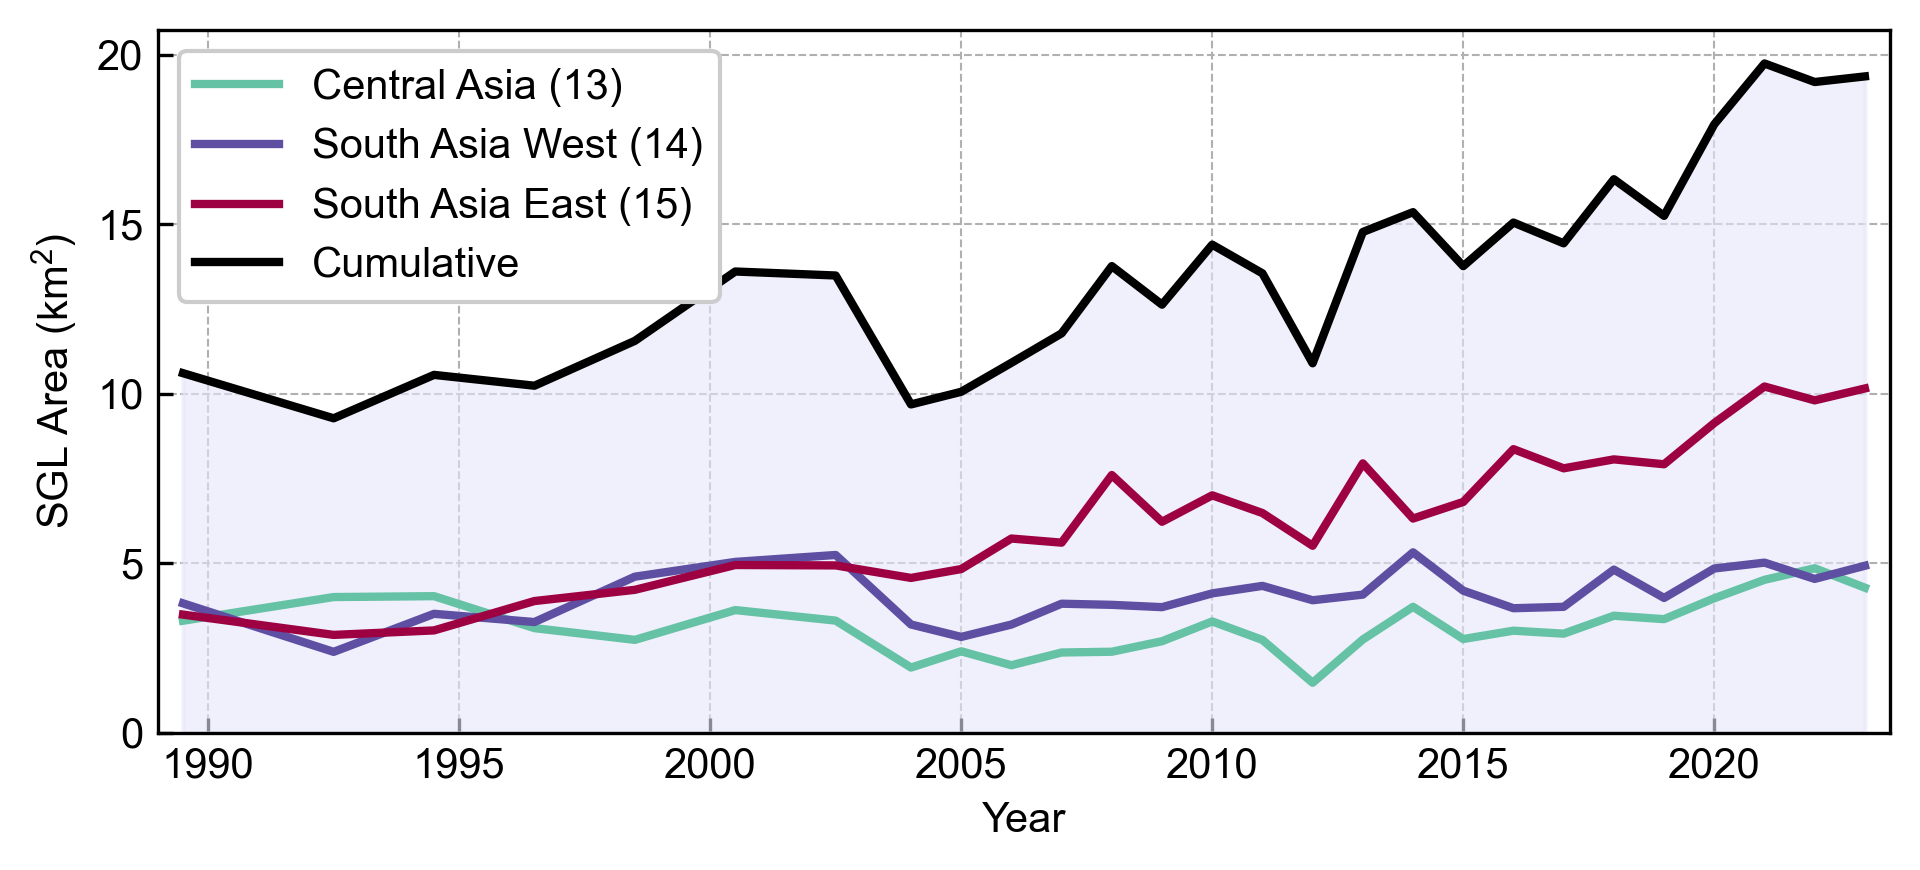

In [40]:
# plot time series of total sgl area across the region, and individual subregions

df_o1 = df_all_nlt.groupby("o1_region").sum(numeric_only=True)
df_o1T = df_o1[c_1yr].T

cs = plt.cm.Spectral(np.linspace(0, 1, 6))

# initiate figure
fig,ax = plt.subplots(figsize=(6.5,3), dpi=300)

# 13
ax.plot( mids, df_o1T['13'].values/(1000*1000),
        label='Central Asia (13)', linewidth=2, color=cs[4], zorder=3)

# 14
ax.plot( mids, df_o1T['14'].values/(1000*1000),
        label='South Asia West (14)', linewidth=2, color=cs[-1], zorder=3)

# 15
ax.plot( mids, df_o1T['15'].values/(1000*1000),
        label='South Asia East (15)', linewidth=2, color=cs[0], zorder=3)

# plot entire region total
sgl_areas = df_all_nlt[c_1yr].sum(axis=0).values
# fill below the curve
ax.fill_between(mids, sgl_areas/(1000*1000), color='lavender', alpha=0.6, zorder=2)
ax.plot( mids, sgl_areas/(1000*1000),
        label="Cumulative", color='black', linewidth=2, zorder=2)

ax.set_xlabel("Year")
ax.set_ylabel("SGL Area (km$^2$)")
ax.set_ylim(0,)
ax.set_xlim(1989,2023.5)

ax.tick_params(axis="both",direction="in")
ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)

ax.legend(framealpha=1)

plt.tight_layout()

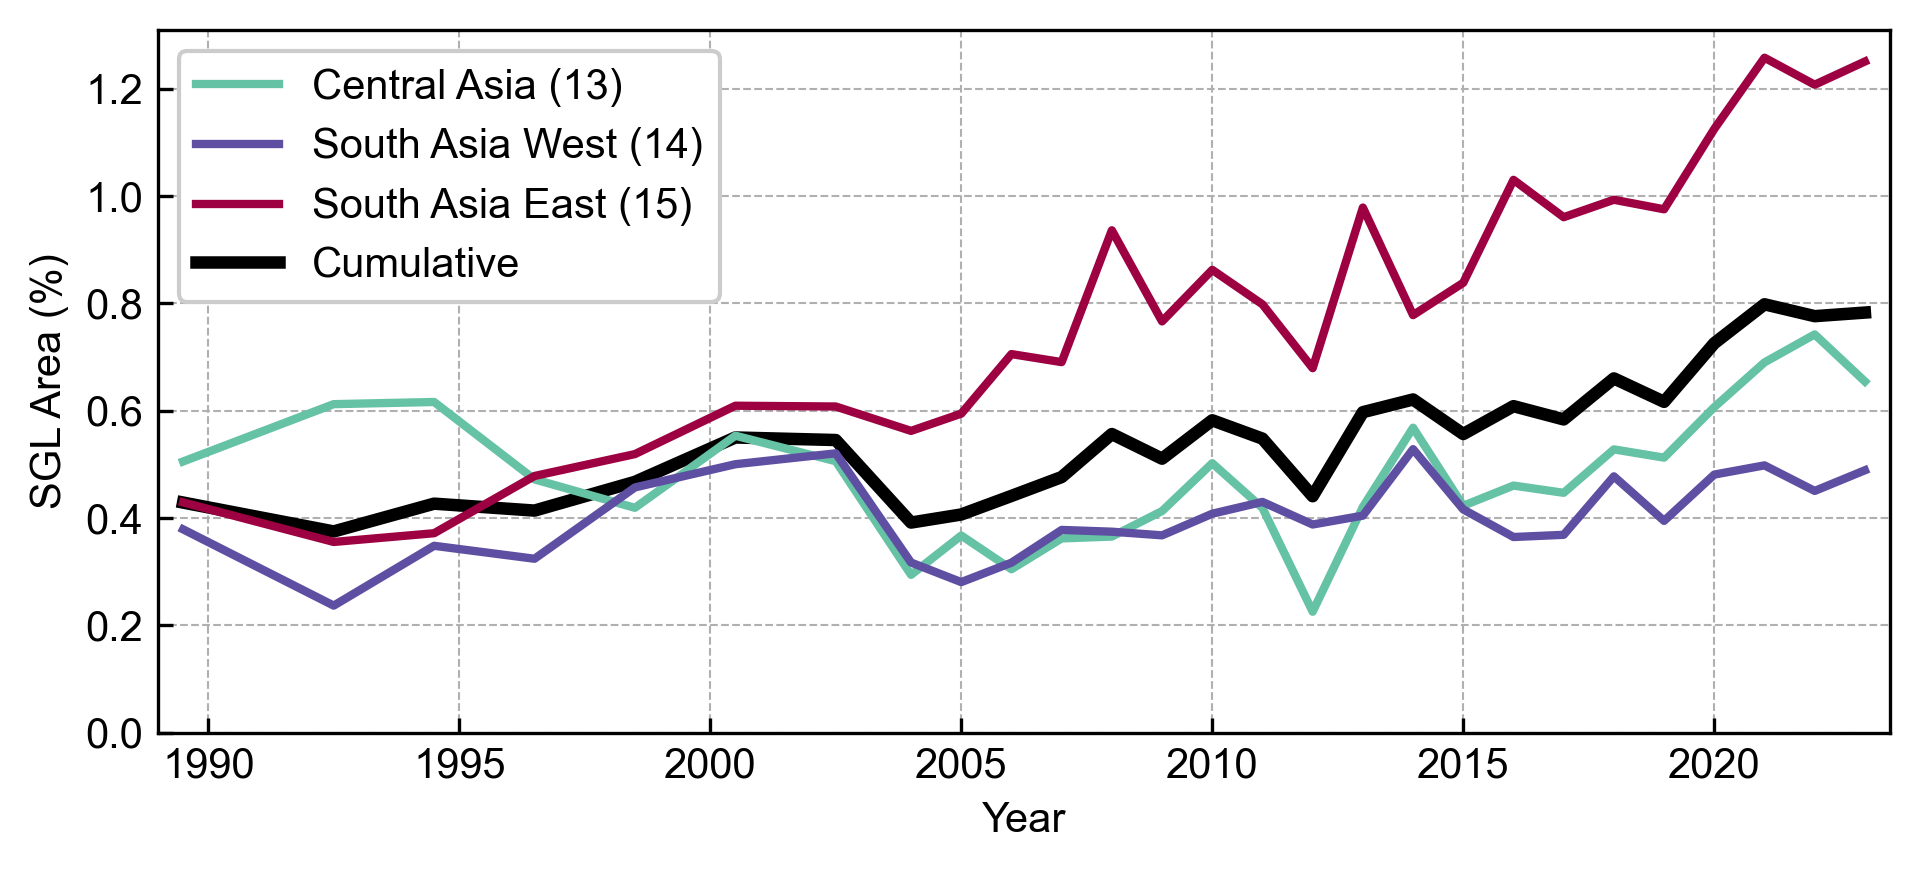

In [41]:
# make a more publication-ready figure that combines total region and subregions

df_o1 = df_all_nlt.groupby("o1_region").sum(numeric_only=True)
df_o1T = df_o1[c_1yr].T

cs = plt.cm.Spectral(np.linspace(0, 1, 6))

fig,ax = plt.subplots(figsize=(6.5,3), dpi=300)

# 13
ax.plot( mids, df_o1T['13'].values / (df_o1.loc['13']['area_dc']*1000*1000) * 100,
        label='Central Asia (13)', linewidth=2, color=cs[4], zorder=3)

# 14
ax.plot( mids, df_o1T['14'].values / (df_o1.loc['14']['area_dc']*1000*1000) * 100,
        label='South Asia West (14)', linewidth=2, color=cs[-1], zorder=3)

# 15
ax.plot( mids, df_o1T['15'].values / (df_o1.loc['15']['area_dc']*1000*1000) * 100,
        label='South Asia East (15)', linewidth=2, color=cs[0], zorder=3)

# plot entire region total
dc_area = np.nansum(df_all_nlt['area_dc'])
sgl_areas = df_all_nlt[c_1yr].sum(axis=0).values/(1000*1000)
ax.plot( mids, sgl_areas/dc_area*100,
        label="Cumulative", color='black', linewidth=3, zorder=2)


ax.set_xlabel("Year")
ax.set_ylabel("SGL Area (%)")
ax.set_ylim(0,)
ax.set_xlim(1989,2023.5)

ax.tick_params(axis="both",direction="in")
ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)

ax.legend(framealpha=1)

plt.tight_layout()



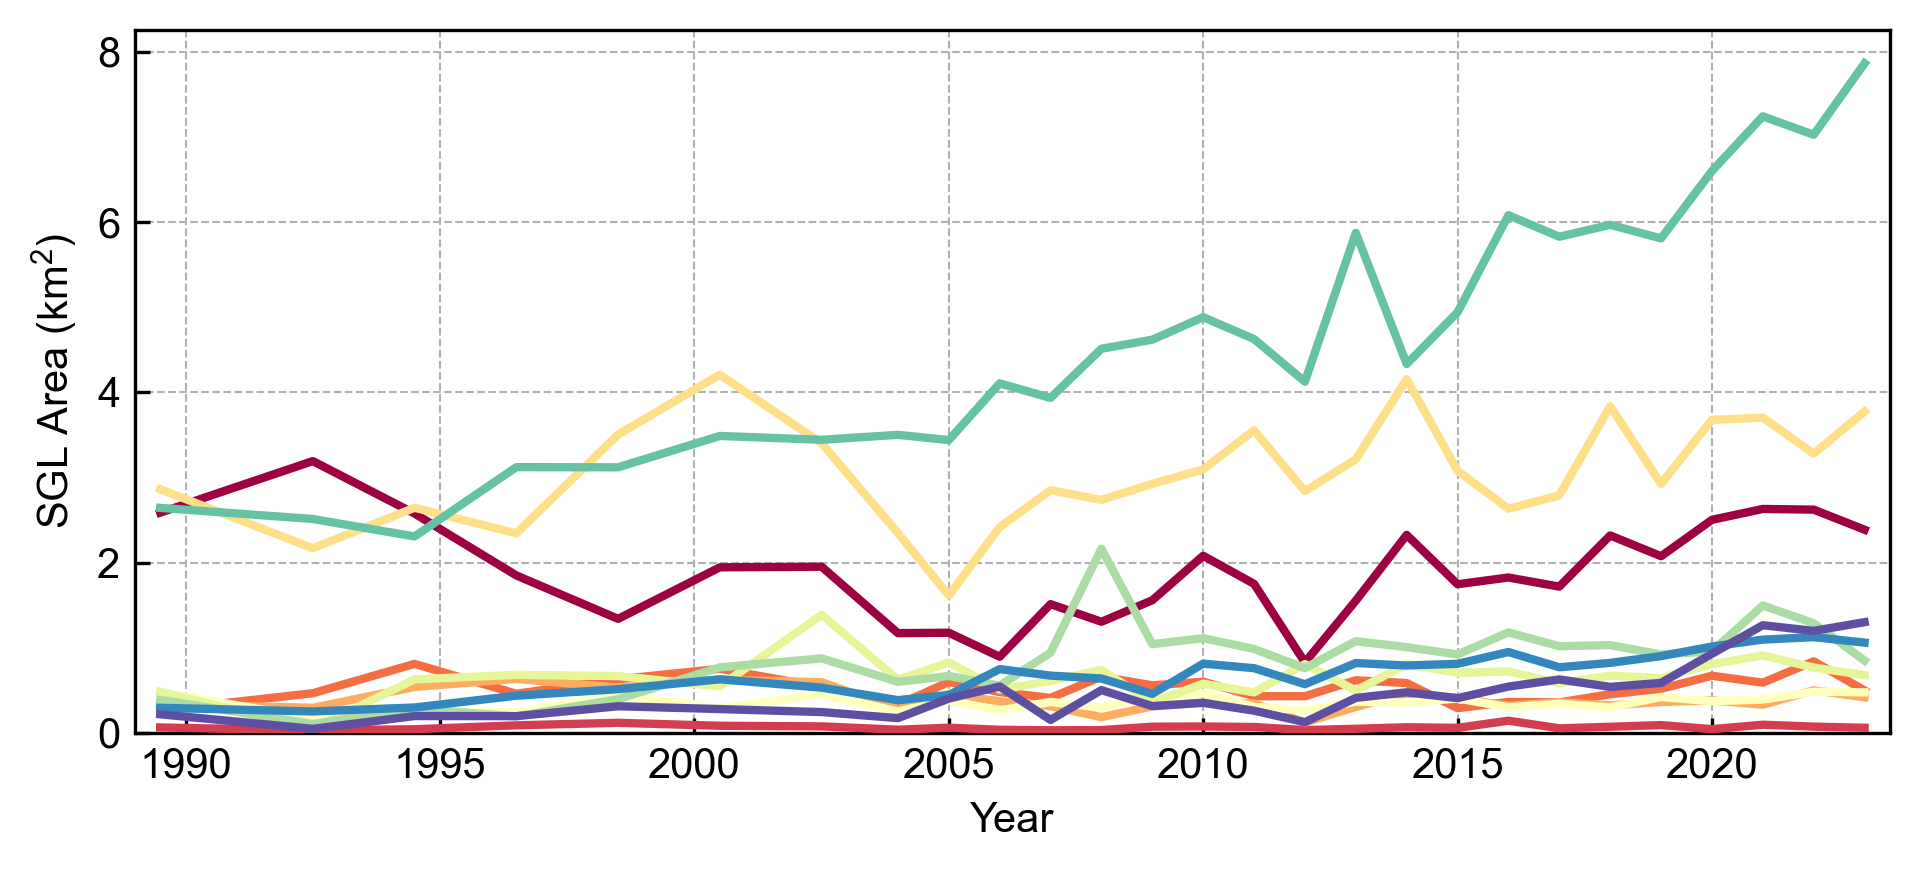

In [42]:
# redo for new subregions

# initiate figure
fig,ax = plt.subplots(figsize=(6.5,3), dpi=300)

# ax2 = ax.twinx() # twinx to hold the entire region, first ax to hold just subregions

for idx,row in subregion_gdf.iterrows():
    subset_df = df_all_nlt[df_all_nlt['region']==row['region']]
    subset_sums = subset_df[c_1yr].sum(axis=0).values
    
    ax.plot( mids, subset_sums/(1000*1000),
            label=row['region'], linewidth=2, color=row['colors'], zorder=3)

# plot entire region total
sgl_areas = df_all_nlt[c_1yr].sum(axis=0).values
# # fill below the curve
# ax.fill_between(mids, sgl_areas/(1000*1000), color='lavender', alpha=0.6, zorder=2)
# ax2.plot( mids, sgl_areas/(1000*1000),
#         label="Cumulative", color='black', linewidth=2, zorder=2)

ax.set_xlabel("Year")
ax.set_ylabel("SGL Area (km$^2$)")

ax.set_ylim(0,)
ax.set_xlim(1989,2023.5)

ax.tick_params(axis="both",direction="in")
ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)

# ax.legend(framealpha=1)

plt.tight_layout()

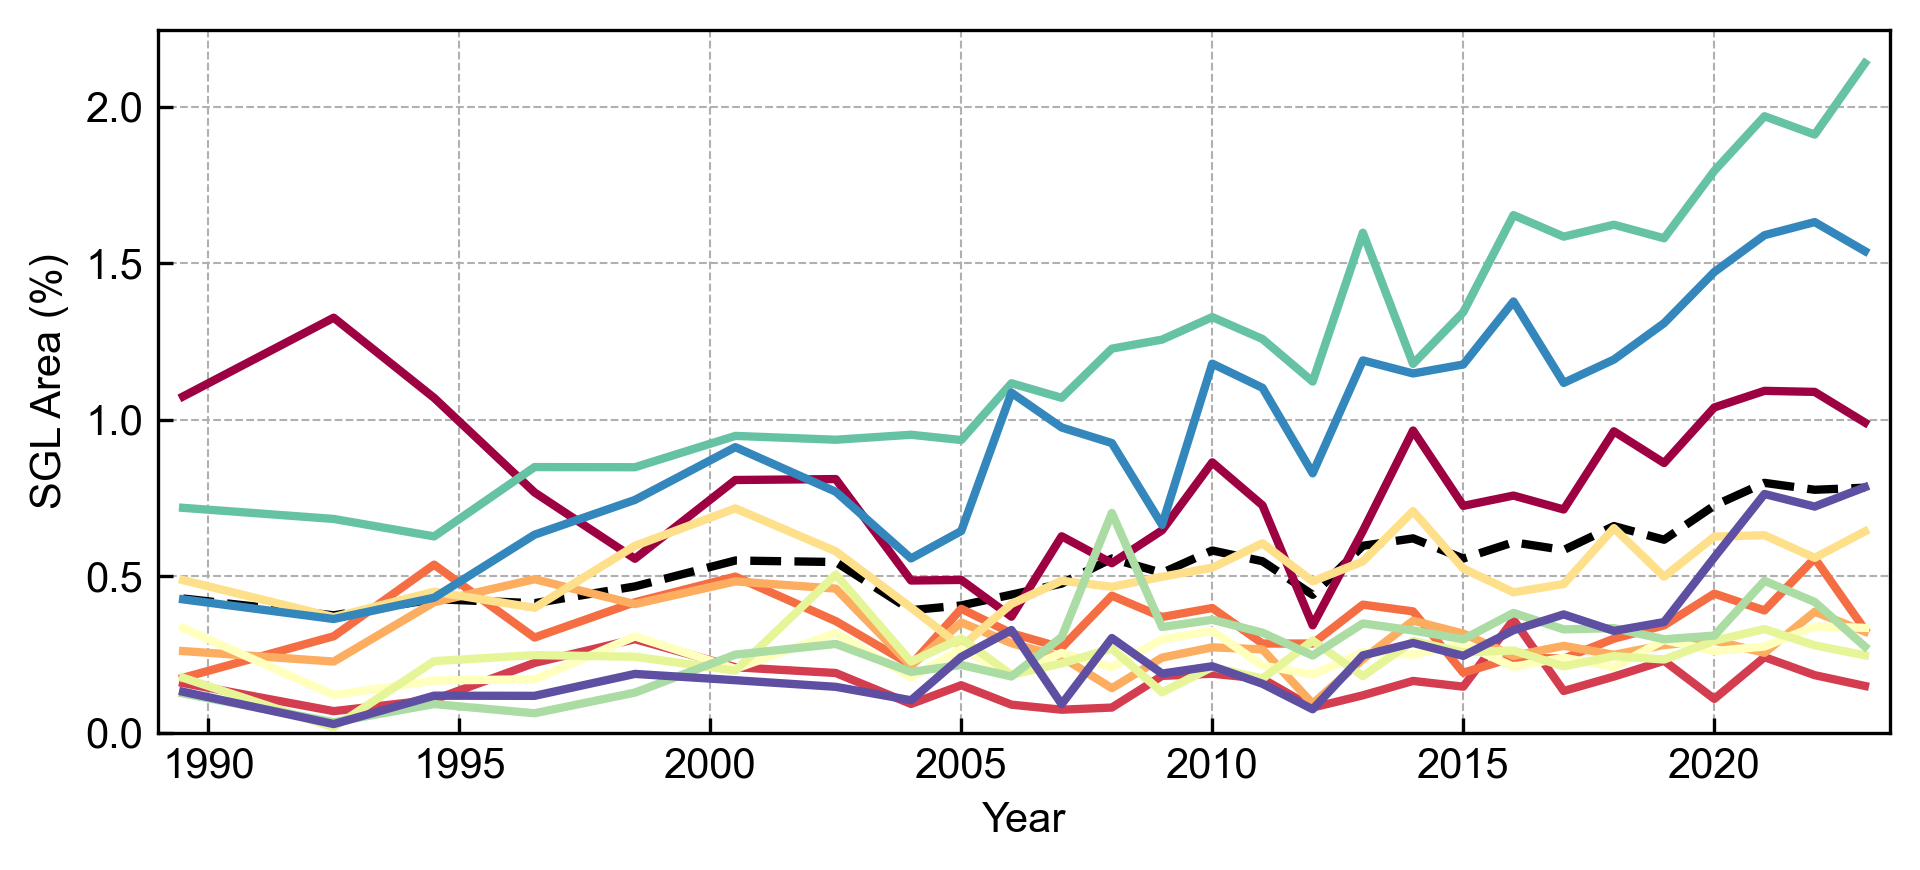

In [43]:
# redo for new subregions

# initiate figure
fig,ax = plt.subplots(figsize=(6.5,3), dpi=300)

# ax2 = ax.twinx() # twinx to hold the entire region, first ax to hold just subregions

for idx,row in subregion_gdf.iterrows():
    subset_df = df_all_nlt[df_all_nlt['region']==row['region']]
    subset_dca = subset_df['area_dc'].sum()*(1000*1000)
    subset_sums = subset_df[c_1yr].sum(axis=0).values
    
    ax.plot( mids, subset_sums/subset_dca*100,
            label=row['region'], linewidth=2, color=row['colors'], zorder=3)

# plot entire region too
sgl_areas = df_all_nlt[c_1yr].sum(axis=0).values
dca_areas = df_all_nlt['area_dc'].sum()*(1000*1000)
ax.plot( mids, sgl_areas/dca_areas*100,
        label="Cumulative", color='black', linewidth=2, zorder=2, linestyle='dashed')

ax.set_xlabel("Year")
ax.set_ylabel("SGL Area (%)")

ax.set_ylim(0,)
ax.set_xlim(1989,2023.5)

ax.tick_params(axis="both",direction="in")
ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)

# ax.legend(framealpha=1)

plt.tight_layout()

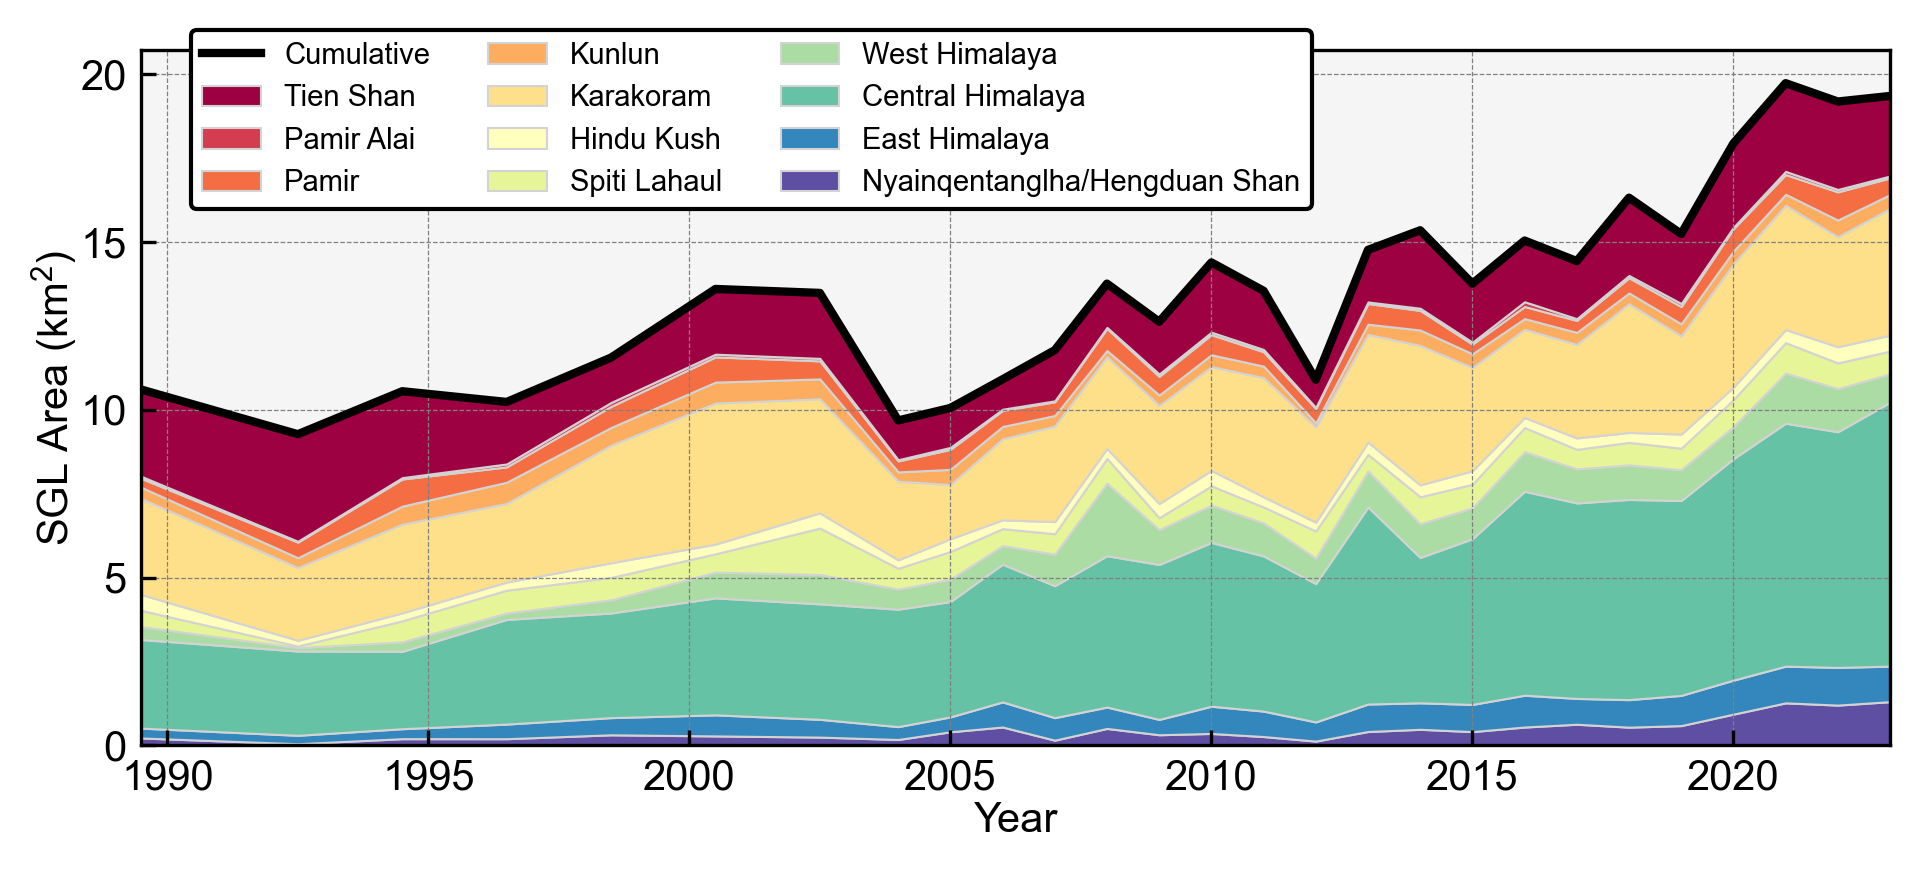

In [44]:
# stacked line plot

# define xs
xs = mids
ys = []
cs = []
rs = []

for idx,row in subregion_gdf[::-1].iterrows():
    subset_df = df_all_nlt[df_all_nlt['region']==row['region']]
    subset_dca = subset_df['area_dc'].sum()*(1000*1000)
    subset_sums = subset_df[c_1yr].sum(axis=0).values
    ys.append(subset_sums/(1000*1000))
    cs.append(row['colors'])
    rs.append(row['region'])
    
# initiate figure
fig,ax = plt.subplots(figsize=(6.5,3), dpi=300)

# stackplot
ax.stackplot(xs, ys, colors=cs, ec='lightgrey', baseline='zero',
             linewidth=0.5, alpha=1, labels=rs)


# plot entire region timerseries in darker color too
sgl_areas = df_all_nlt[c_1yr].sum(axis=0).values
dca_areas = df_all_nlt['area_dc'].sum()*(1000*1000)
ax.plot( mids, sgl_areas/(1000*1000),
        label="Cumulative", color='black', linewidth=2, zorder=2, linestyle='solid')

ax.set_facecolor('whitesmoke')
ax.set_xlabel("Year", labelpad=1)
ax.set_ylabel("SGL Area (km$^2$)", labelpad=0)

ax.set_ylim(0,)
ax.set_xlim(1989.5,2023)

ax.tick_params(axis="both",direction="in")
ax.grid(linestyle='dashed', linewidth=0.3, c='grey')

ax.legend(loc='upper left', bbox_to_anchor=(0.02,1.05), ncols=3,
          framealpha=1, reverse=True, fontsize=7, edgecolor='black',)

plt.tight_layout()

save=0
if save:
    plt.savefig(os.path.join(folder_HMA,'Figures','timeseries',f'timeseries.png'),
                transparent=False, bbox_inches='tight', dpi=300)

In [45]:
# quick format to df to save
df_out = pd.DataFrame(ys, columns=xs)
df_out['region'] = rs
df_out = df_out.set_index('region')
df_out.loc['Total'] = df_out.sum(axis=0)
df_out

,1989.5,1992.5,1994.5,1996.5,1998.5,2000.5,2002.5,2004.0,2005.0,2006.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
region,,,,,,,,,,,,,,,,,,,,,
Nyainqentanglha/Hengduan Shan,0.2169,0.0459,0.1962,0.1953,0.3114,0.2781,0.2430,0.1719,0.4014,0.5436,...,0.4752,0.4068,0.5427,0.6264,0.5391,0.5859,0.9279,1.2636,1.1970,1.2996
East Himalaya,0.2934,0.2502,0.2970,0.4356,0.5121,0.6282,0.5301,0.3834,0.4437,0.7479,...,0.7902,0.8100,0.9486,0.7695,0.8208,0.9009,1.0134,1.0944,1.1232,1.0593
Central Himalaya,2.6424,2.5119,2.3067,3.1212,3.1194,3.4875,3.4425,3.5010,3.4389,4.1058,...,4.3335,4.9410,6.0813,5.8284,5.9688,5.8095,6.6015,7.2432,7.0272,7.8660
West Himalaya,0.3861,0.1035,0.2826,0.1917,0.3951,0.7686,0.8739,0.5985,0.6669,0.5535,...,1.0062,0.9198,1.1790,1.0170,1.0296,0.9198,0.9558,1.4949,1.2870,0.8478
Spiti Lahaul,0.4815,0.0468,0.6273,0.6804,0.6660,0.5445,1.3860,0.6228,0.8262,0.5076,...,0.8046,0.7038,0.7209,0.5814,0.6714,0.6417,0.8064,0.9081,0.7659,0.6786
Hindu Kush,0.4743,0.1710,0.2367,0.2421,0.4365,0.2898,0.4518,0.2502,0.3789,0.2619,...,0.3537,0.4023,0.2988,0.3402,0.2970,0.4203,0.3699,0.3906,0.4815,0.4752
Karakoram,2.8611,2.1681,2.6442,2.3427,3.5046,4.2066,3.4020,2.3463,1.6146,2.4156,...,4.1562,3.0789,2.6325,2.7882,3.8367,2.9250,3.6774,3.7035,3.2796,3.7746
Kunlun,0.3366,0.2934,0.5382,0.6327,0.5301,0.6237,0.5940,0.2763,0.4545,0.3690,...,0.4617,0.4086,0.3168,0.3582,0.3213,0.3618,0.3798,0.3294,0.4986,0.4167
Pamir,0.2646,0.4644,0.8091,0.4581,0.6282,0.7515,0.5373,0.3267,0.5967,0.4788,...,0.5841,0.2889,0.3618,0.3573,0.4527,0.5166,0.6696,0.5886,0.8397,0.4968


In [46]:
df_out2 = df_out/df_out.loc['Total']
df_out2

,1989.5,1992.5,1994.5,1996.5,1998.5,2000.5,2002.5,2004.0,2005.0,2006.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
region,,,,,,,,,,,,,,,,,,,,,
Nyainqentanglha/Hengduan Shan,0.020451,0.004949,0.018588,0.019080,0.026941,0.020442,0.018018,0.017751,0.039914,0.049819,...,0.030948,0.029558,0.036065,0.043392,0.033021,0.038430,0.051705,0.064010,0.062365,0.067132
East Himalaya,0.027665,0.026977,0.028138,0.042557,0.044304,0.046176,0.039306,0.039591,0.044120,0.068542,...,0.051462,0.058854,0.063038,0.053304,0.050276,0.059091,0.056469,0.055439,0.058520,0.054719
Central Himalaya,0.249151,0.270839,0.218537,0.304933,0.269875,0.256351,0.255255,0.361524,0.341955,0.376278,...,0.282223,0.359011,0.404127,0.403741,0.365601,0.381051,0.367854,0.366919,0.366126,0.406323
West Himalaya,0.036405,0.011160,0.026774,0.018729,0.034182,0.056496,0.064798,0.061803,0.066315,0.050726,...,0.065530,0.066832,0.078349,0.070449,0.063065,0.060331,0.053260,0.075727,0.067054,0.043794
Spiti Lahaul,0.045401,0.005046,0.059430,0.066473,0.057619,0.040024,0.102769,0.064312,0.082155,0.046519,...,0.052400,0.051138,0.047907,0.040274,0.041125,0.042090,0.044935,0.046002,0.039904,0.035053
Hindu Kush,0.044722,0.018438,0.022425,0.023653,0.037764,0.021302,0.033500,0.025836,0.037677,0.024002,...,0.023035,0.029231,0.019856,0.023566,0.018192,0.027568,0.020612,0.019787,0.025087,0.024547
Karakoram,0.269773,0.233770,0.250512,0.228875,0.303200,0.309209,0.252252,0.242286,0.160551,0.221379,...,0.270676,0.223712,0.174940,0.193142,0.235006,0.191854,0.204915,0.187608,0.170871,0.194979
Kunlun,0.031738,0.031635,0.050989,0.061813,0.045862,0.045845,0.044044,0.028532,0.045194,0.033817,...,0.030069,0.029689,0.021053,0.024813,0.019680,0.023731,0.021163,0.016686,0.025978,0.021525
Pamir,0.024949,0.050073,0.076654,0.044755,0.054349,0.055239,0.039840,0.033736,0.059334,0.043880,...,0.038040,0.020991,0.024043,0.024751,0.027729,0.033884,0.037312,0.029817,0.043749,0.025662


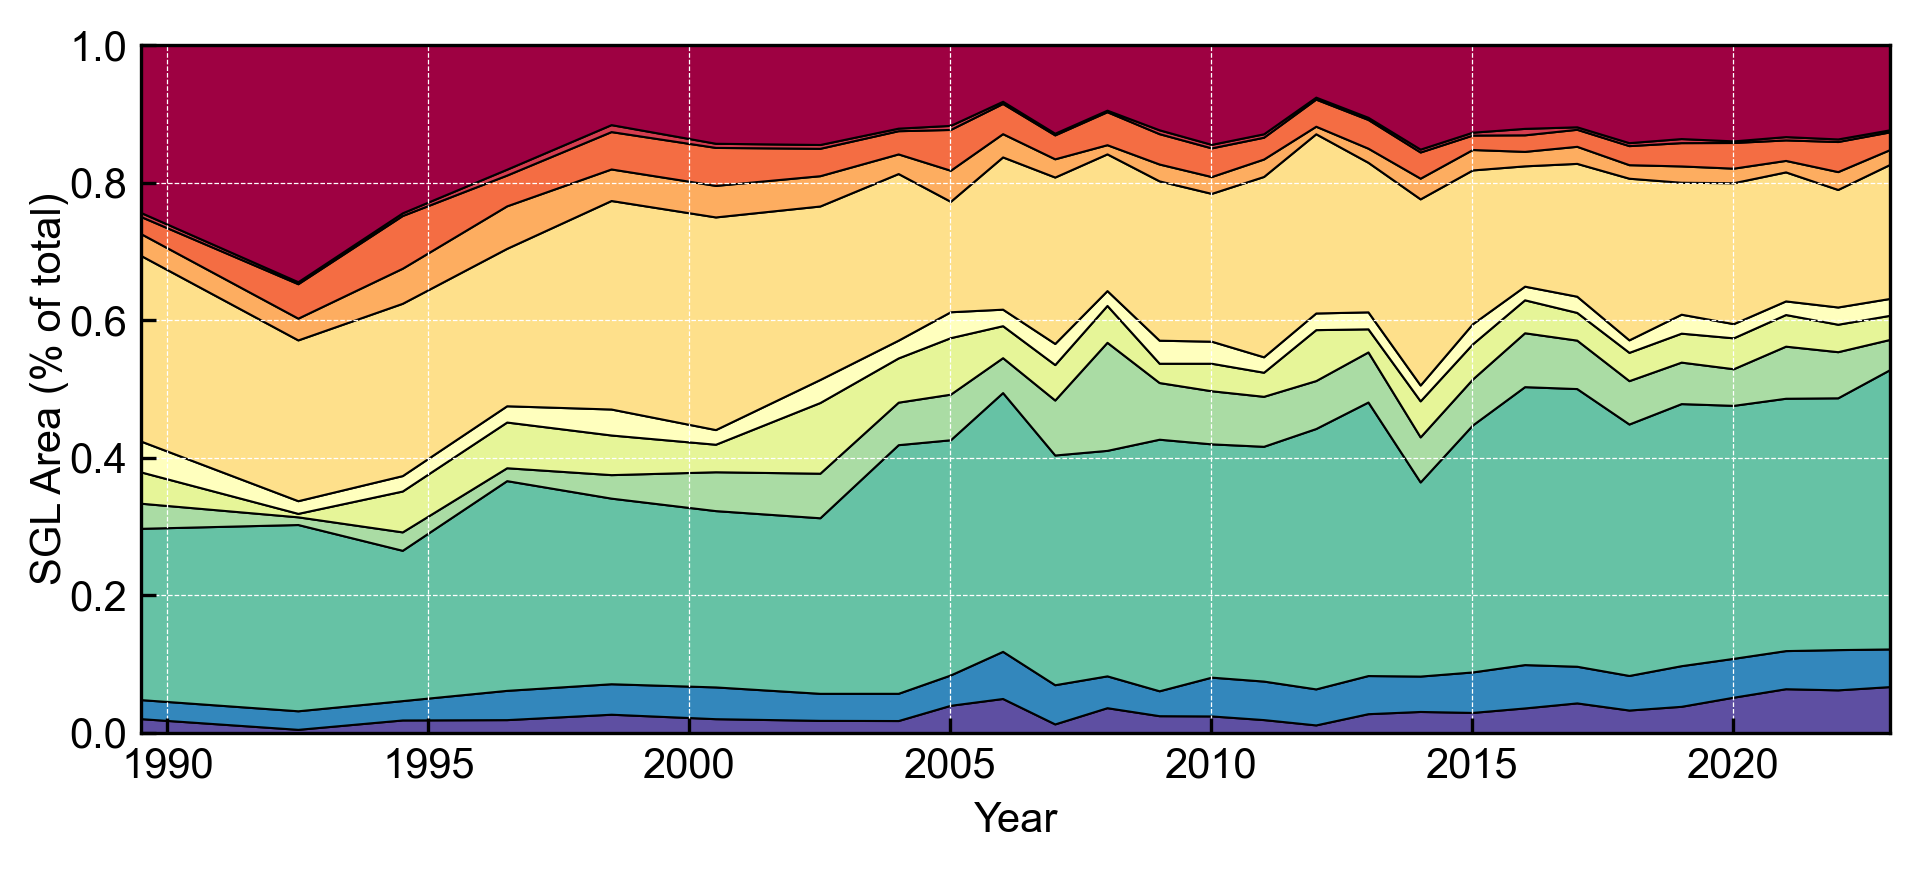

In [47]:
# stacked line plot, normalized to 1

# define xs
xs = mids
ys = []
cs = []

for idx,row in subregion_gdf[::-1].iterrows():
    subset_df = df_all_nlt[df_all_nlt['region']==row['region']]
    subset_dca = subset_df['area_dc'].sum()*(1000*1000)
    subset_sums = subset_df[c_1yr].sum(axis=0).values
    ys.append(subset_sums/(1000*1000))
    cs.append(row['colors'])

ys = np.array(ys)
ys = ys/np.sum(ys, axis=0)

# initiate figure
fig,ax = plt.subplots(figsize=(6.5,3), dpi=300)

ax.stackplot(xs,ys, colors=cs, ec='black',
             linewidth=0.5, alpha=1)


# plot entire region too
sgl_areas = df_all_nlt[c_1yr].sum(axis=0).values
dca_areas = df_all_nlt['area_dc'].sum()*(1000*1000)
# ax.plot( mids, sgl_areas/(1000*1000),
#         label="Cumulative", color='black', linewidth=2, zorder=2, linestyle='solid')

ax.set_xlabel("Year")
ax.set_ylabel("SGL Area (% of total)", labelpad=0)

ax.set_ylim(0,1)
ax.set_xlim(1989.5,2023)

ax.tick_params(axis="both",direction="in")
ax.grid(linestyle='dashed', linewidth=0.3, c='white')

# ax.legend(framealpha=1)

plt.tight_layout()

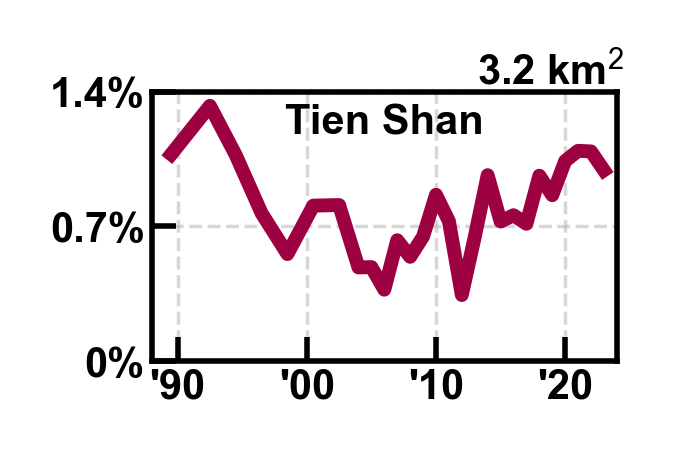

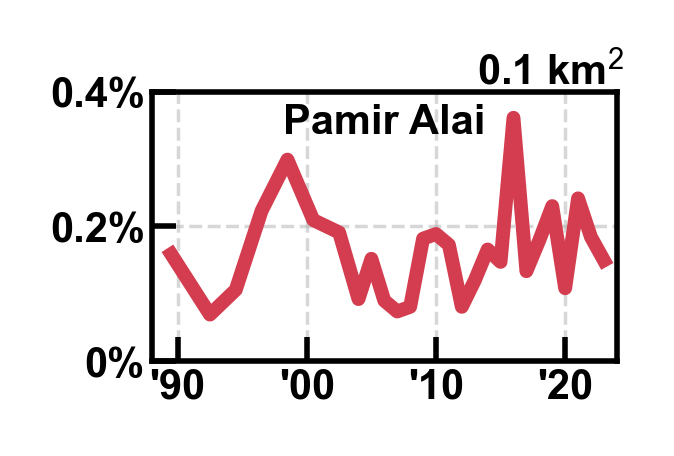

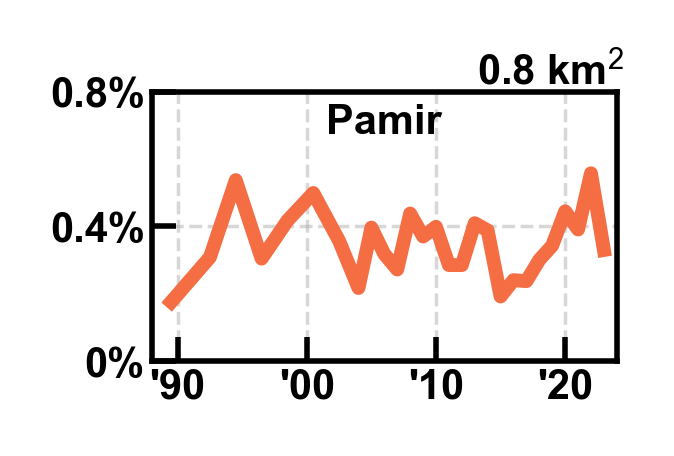

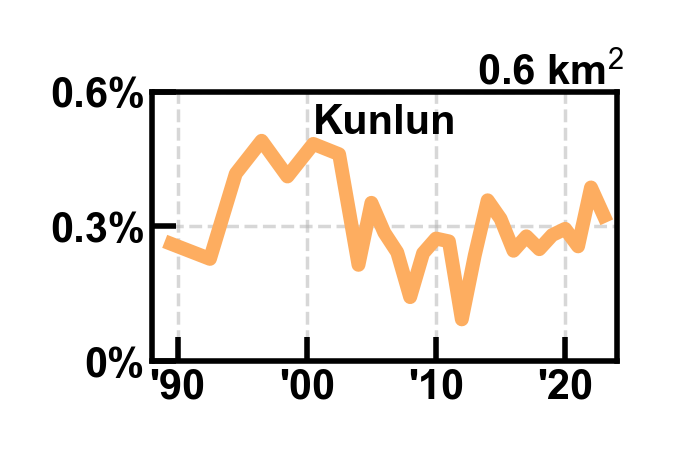

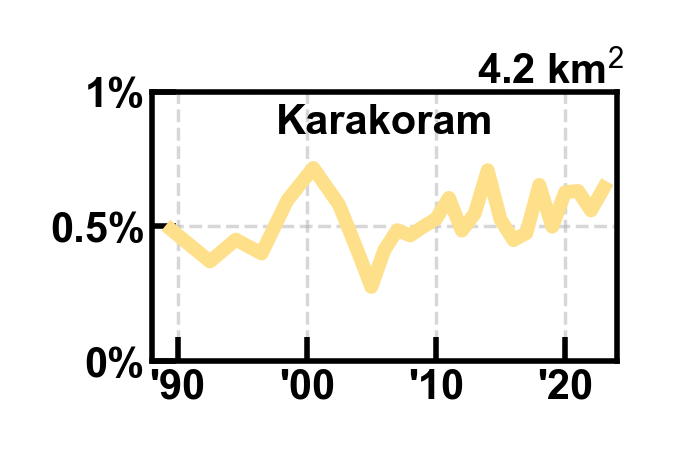

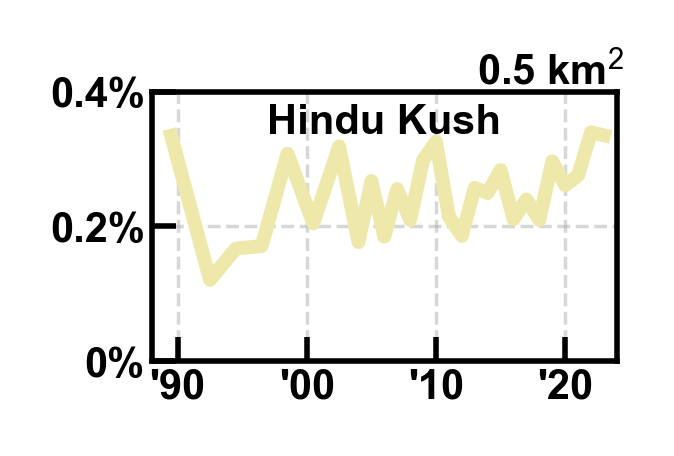

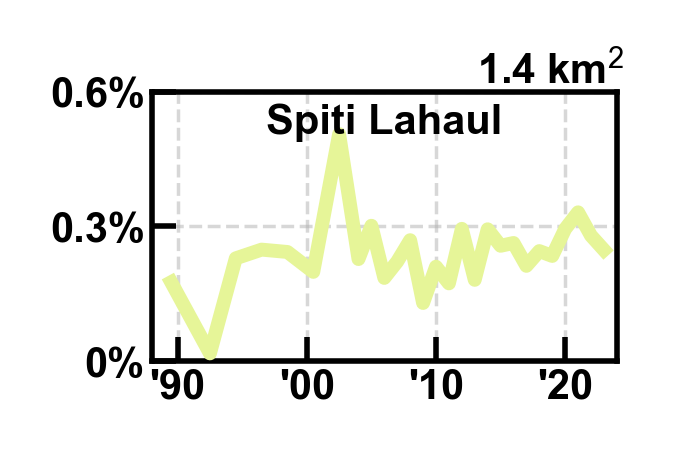

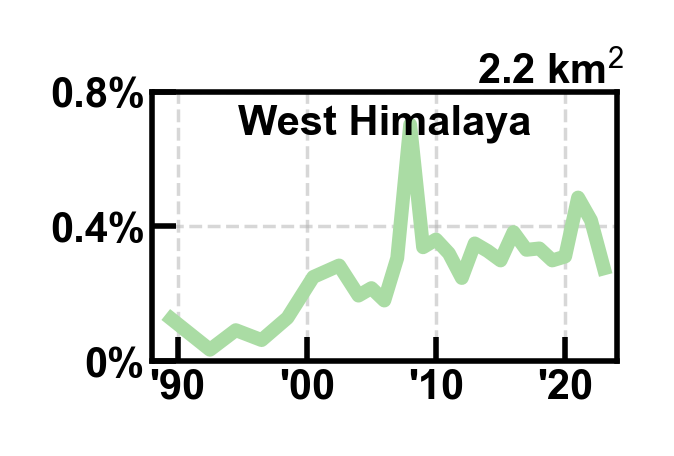

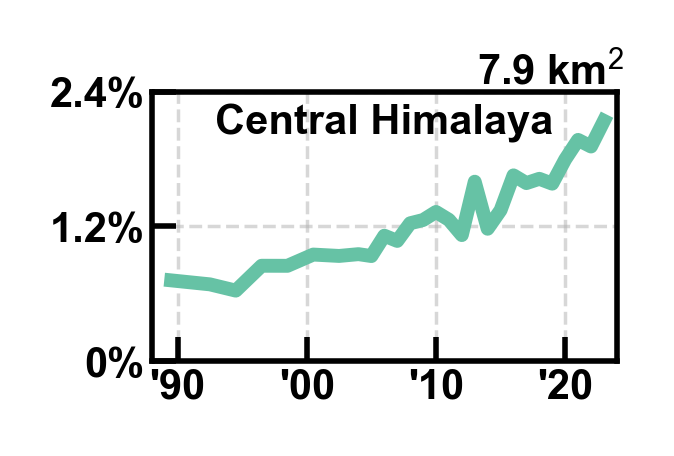

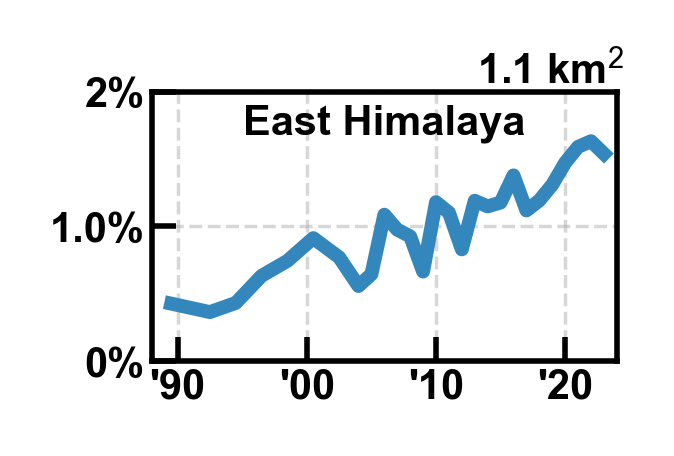

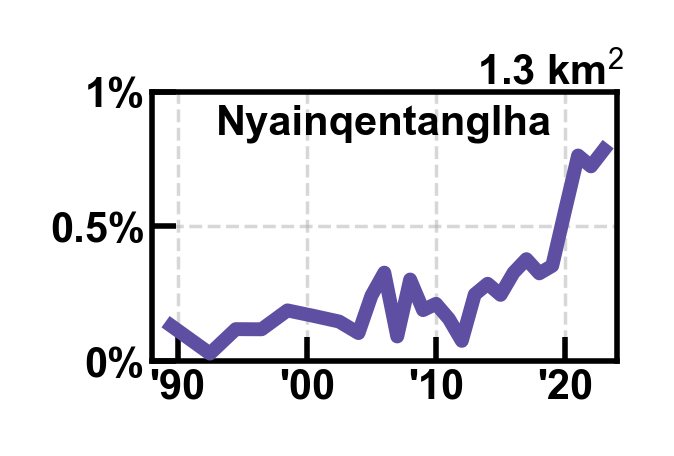

In [104]:
# individual plots for each subregion (% and total area)
ylimits = {'Tien Shan':(0,1.4), 'Pamir Alai':(0,0.4), 'Pamir':(0,0.8), 'Kunlun':(0,0.6), 'Karakoram':(0,1),
           'Hindu Kush':(0,0.4), 'Spiti Lahaul':(0,0.6), 'West Himalaya':(0,0.8), 'Central Himalaya':(0,2.4),
           'East Himalaya':(0,2), 'Nyainqentanglha/Hengduan Shan':(0,1) }

colors = plt.cm.Spectral(np.linspace(0, 1, len(subregion_gdf)))
subregion_gdf['colors']=list(colors)

for idx,row in subregion_gdf.iterrows():
    # if idx>0: continue
    subset_df = df_all_nlt[df_all_nlt['region']==row['region']]
    subset_dca = subset_df['area_dc'].sum()*(1000*1000)
    subset_sums = subset_df[c_1yr].sum(axis=0).values
    label = row['region']
    color = row['colors']
    ylims = ylimits[label]
    yticks = [0, ylims[1]/2, ylims[1]]
    
    if label == "Hindu Kush":
        color='palegoldenrod'
    
    if label == "Nyainqentanglha/Hengduan Shan":
        label = "Nyainqentanglha"
    
    # initiate figure 
    fig,ax = plt.subplots(figsize=(1.2,0.7), dpi=500)
    fig.patch.set_alpha(0)
    ax.plot( mids, subset_sums/subset_dca*100,
            label=label, linewidth=2, color=color, zorder=3)
        
    ax.set_xlim(1988,2024)
    
    ax.set_xticks([1990,2000,2010,2020], ["'90","'00","'10","'20"], fontsize=6, fontweight='bold')
    ax.set_ylim(ylims)
    ax.set_yticks(yticks, [f"{y}%" for y in yticks], fontsize=6, fontweight='bold')
    
    ax.tick_params(axis="both", direction="in", pad=1)
    ax.grid(zorder=1, linestyle='dashed', linewidth=0.5, alpha=0.5)

    ax.set_title(label, fontsize=6, y=1, pad=-6, weight='bold')
    
    # calculate the area that the top of the graph represents
    ymax = (np.array(ylims)[-1]/100*subset_dca)/(1000*1000)
    ymax = (np.nanmax(subset_sums))/(1000*1000)
    ax.text(0.7, 1.03, f"{round(ymax,1)} km$^2$", transform=ax.transAxes, fontsize=6, fontweight='bold')
    
    # twinx to show area in km2
    # ax2 = ax.twinx()
    # ylims2 = (np.array(ylims)/100*subset_dca)/(1000*1000)
    # yticks2 = [ylims2[1]]
    # ax2.set_ylim(ylims2)
    # ax2.set_yticks(yticks2,[f"{round(yticks2[0],1)}\nkm$^2$"], fontsize=6)
    # ax2.tick_params(axis="both",direction="out", length=2, pad=-1)
    
    # plt.tight_layout()
    
    save=1
    if save:
        plt.savefig(os.path.join(folder_HMA,'Figures','Study Area','region both',f'{label}.png'),
                   dpi=500, bbox_inches = "tight")

   

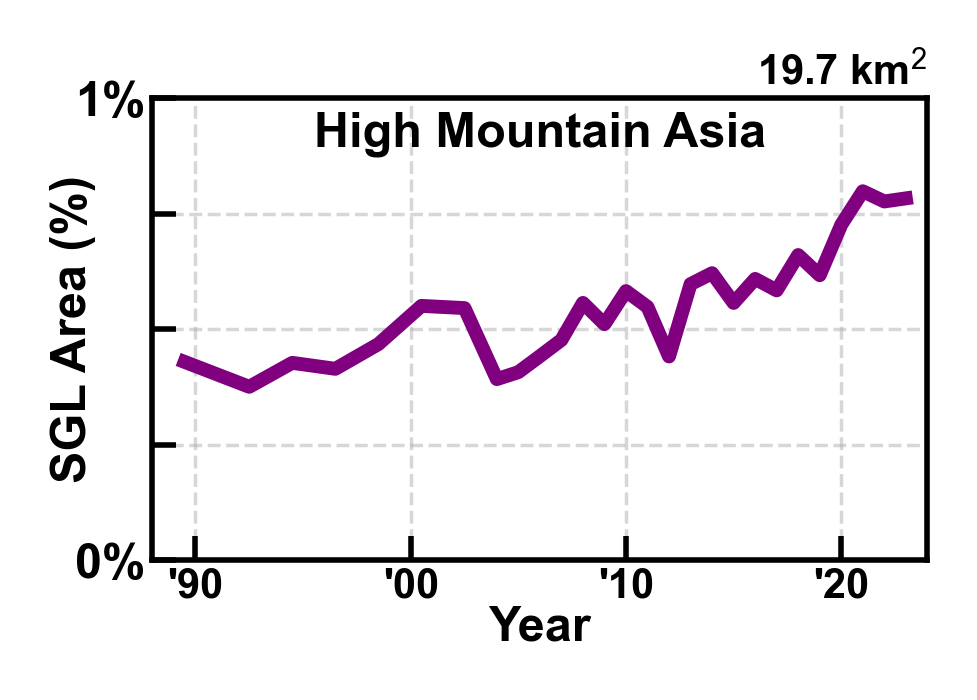

In [103]:
# matching plot for the whole thing
subset_df = df_all_nlt
subset_dca = subset_df['area_dc'].sum()*(1000*1000)
subset_sums = subset_df[c_1yr].sum(axis=0).values
label = 'High Mountain Asia'
color = 'purple'
ylims = (0,1)
yticks = [0,0.25,0.5,0.75,1]
ylabs = ['0%',"","","","1%"]

# initiate figure 
fig,ax = plt.subplots(figsize=(2,1.2), dpi=500)
fig.patch.set_alpha(0)
ax.plot( mids, subset_sums/subset_dca*100,
        label=label, linewidth=2, color=color, zorder=3)

ax.set_xlim(1988,2024)

ax.set_xticks([1990,2000,2010,2020], ["'90","'00","'10","'20"], fontsize=6, fontweight='bold')
ax.set_ylim(ylims)
ax.set_yticks(yticks, ylabs, fontsize=7, fontweight='bold')

ax.tick_params(axis="both", direction="in", pad=1)
ax.grid(zorder=1, linestyle='dashed', linewidth=0.5, alpha=0.5)

ax.set_title(label, fontsize=7, y=1, pad=-7, weight='bold')

# calculate the area that the top of the graph represents
ymax = (np.array(ylims)[-1]/100*subset_dca)/(1000*1000)
ymax = (np.nanmax(subset_sums))/(1000*1000)
ax.text(0.78, 1.03, f"{round(ymax,1)} km$^2$", transform=ax.transAxes, fontsize=6, fontweight='bold')

ax.set_xlabel("Year", fontsize=7, fontweight='bold', labelpad=0)
ax.set_ylabel("SGL Area (%)", fontsize=7, fontweight='bold', labelpad=-3)

# plt.tight_layout()

save=1
if save:
    plt.savefig(os.path.join(folder_HMA,'Figures','Study Area','region both',f'{"HMA"}.png'),
               dpi=500, bbox_inches = "tight")

   

In [49]:
# # individual plots for each subregion (total area)
# ylimits = {'Tien Shan':(0,3), 'Pamir Alai':(0,0.2), 'Pamir':(0,1), 'Kunlun':(0,0.8), 'Karakoram':(0,5),
#            'Hindu Kush':(0,0.6), 'Spiti Lahaul':(0,1.4), 'West Himalaya':(0,2.4), 'Central Himalaya':(0,8),
#            'East Himalaya':(0,1.2), 'Nyainqentanglha/Hengduan Shan':(0,1.8) }

# colors = plt.cm.Spectral(np.linspace(0, 1, len(subregion_gdf)))
# subregion_gdf['colors']=list(colors)

# for idx,row in subregion_gdf.iterrows():
#     # if idx>0: continue
#     subset_df = df_all_nlt[df_all_nlt['region']==row['region']]
#     subset_dca = subset_df['area_dc'].sum()*(1000*1000)
#     subset_sums = subset_df[c_1yr].sum(axis=0).values
#     label = row['region']
#     color = row['colors']
#     ylims = ylimits[label]
#     yticks = [0, ylims[1]/2, ylims[1]]
    
#     if label == "Hindu Kush":
#         color='palegoldenrod'
    
#     if label == "Nyainqentanglha/Hengduan Shan":
#         label = "Nyainqentanglha"
    
#     # initiate figure 
#     fig,ax = plt.subplots(figsize=(1.2,0.7), dpi=500)
#     fig.patch.set_alpha(0)
#     ax.plot( mids, subset_sums/(1000*1000),
#             label=label, linewidth=2, color=color, zorder=3)
        
#     ax.set_xlim(1988,2024)
    
#     ax.set_xticks([1990,2000,2010,2020], ["'90","'00","'10","'20"], fontsize=6)
#     ax.set_ylim(ylims)# individual plots for each subregion (% area)
    
# ylimits = {'Tien Shan':(0,1.4), 'Pamir Alai':(0,0.4), 'Pamir':(0,0.8), 'Kunlun':(0,0.6), 'Karakoram':(0,0.8),
#            'Hindu Kush':(0,0.4), 'Spiti Lahaul':(0,0.6), 'West Himalaya':(0,0.8), 'Central Himalaya':(0,2.4),
#            'East Himalaya':(0,2), 'Nyainqentanglha/Hengduan Shan':(0,1) }

# colors = plt.cm.Spectral(np.linspace(0, 1, len(subregion_gdf)))
# subregion_gdf['colors']=list(colors)

# for idx,row in subregion_gdf.iterrows():
#     # if idx>0: continue
#     subset_df = df_all_nlt[df_all_nlt['region']==row['region']]
#     subset_dca = subset_df['area_dc'].sum()*(1000*1000)
#     subset_sums = subset_df[c_1yr].sum(axis=0).values
#     label = row['region']
#     color = row['colors']
#     ylims = ylimits[label]
#     yticks = [0, ylims[1]/2, ylims[1]]
    
#     if label == "Hindu Kush":
#         color='palegoldenrod'
    
#     if label == "Nyainqentanglha/Hengduan Shan":
#         label = "Nyainqentanglha"
    
#     # initiate figure 
#     fig,ax = plt.subplots(figsize=(1.2,0.7), dpi=500)
#     fig.patch.set_alpha(0)
#     ax.plot( mids, subset_sums/subset_dca*100,
#             label=label, linewidth=2, color=color, zorder=3)
        
#     ax.set_xlim(1988,2024)
    
#     ax.set_xticks([1990,2000,2010,2020], ["'90","'00","'10","'20"], fontsize=6)
#     ax.set_ylim(ylims)
#     ax.set_yticks(yticks,yticks, fontsize=6)
    
#     ax.tick_params(axis="both",direction="in", pad=1)
#     ax.grid(zorder=1, linestyle='dashed', linewidth=0.5, alpha=0.5)

#     ax.set_title(label, fontsize=6, y=1, pad=-6)
    
#     save=1
#     if save:
#         plt.savefig(os.path.join(folder_HMA,'Figures','Study Area','region percents',f'{label}.png'),
#                    dpi=500)

#     # plt.tight_layout()
#     ax.set_yticks(yticks,yticks, fontsize=6)
    
#     ax.tick_params(axis="both",direction="in", pad=1)
#     ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)

#     ax.set_title(label, fontsize=6, pad=0)
    
#     save=0
#     if save:
#         plt.savefig(os.path.join(folder_HMA,'Figures','Study Area','region areas',f'{label}.png'),
#                    dpi=500)

#     # plt.tight_layout()

In [50]:
# # individual plots for each subregion (% area)
# ylimits = {'Tien Shan':(0,1.4), 'Pamir Alai':(0,0.4), 'Pamir':(0,0.8), 'Kunlun':(0,0.6), 'Karakoram':(0,0.8),
#            'Hindu Kush':(0,0.4), 'Spiti Lahaul':(0,0.6), 'West Himalaya':(0,0.8), 'Central Himalaya':(0,2.4),
#            'East Himalaya':(0,2), 'Nyainqentanglha/Hengduan Shan':(0,1) }

# colors = plt.cm.Spectral(np.linspace(0, 1, len(subregion_gdf)))
# subregion_gdf['colors']=list(colors)

# for idx,row in subregion_gdf.iterrows():
#     # if idx>0: continue
#     subset_df = df_all_nlt[df_all_nlt['region']==row['region']]
#     subset_dca = subset_df['area_dc'].sum()*(1000*1000)
#     subset_sums = subset_df[c_1yr].sum(axis=0).values
#     label = row['region']
#     color = row['colors']
#     ylims = ylimits[label]
#     yticks = [0, ylims[1]/2, ylims[1]]
    
#     if label == "Hindu Kush":
#         color='palegoldenrod'
    
#     if label == "Nyainqentanglha/Hengduan Shan":
#         label = "Nyainqentanglha"
    
#     # initiate figure 
#     fig,ax = plt.subplots(figsize=(1.2,0.7), dpi=500)
#     fig.patch.set_alpha(0)
#     ax.plot( mids, subset_sums/subset_dca*100,
#             label=label, linewidth=2, color=color, zorder=3)
        
#     ax.set_xlim(1988,2024)
    
#     ax.set_xticks([1990,2000,2010,2020], ["'90","'00","'10","'20"], fontsize=6)
#     ax.set_ylim(ylims)
#     ax.set_yticks(yticks,yticks, fontsize=6)
    
#     ax.tick_params(axis="both",direction="in", pad=1)
#     ax.grid(zorder=1, linestyle='dashed', linewidth=0.5, alpha=0.5)

#     ax.set_title(label, fontsize=6, y=1, pad=-6)
    
#     save=0
#     if save:
#         plt.savefig(os.path.join(folder_HMA,'Figures','Study Area','region percents',f'{label}.png'),
#                    dpi=500)

#     # plt.tight_layout()

In [51]:
# # plot the annual timeseries of each o2region, grouped in plots by o3region
# fig,axs = plt.subplots(3,1, figsize=(6.5,7), sharey='row')

# # do you want to count number of total glaciers, or non-lake-temrinating?
# count_o2 = df_all_nlt.groupby("o2_region").count()['rgi_id']

# # iterate through a color ramp. new color for each line
# colors_to_use = iter( list(plt.cm.tab10(np.linspace(0, 0.69, 7))) +
#                       list(plt.cm.tab10(np.linspace(0, 0.69, 7))) )

# # excluding lake-terminating
# df_o2 = df_all_nlt.groupby("o2_region").sum(numeric_only=True)
# subset = df_o2[c_1yr].T
# for c in subset.columns:
#     ax = axs[int(c[:2])-13]
#     dc_area = df_o2.loc[c]['area_dc']*1000*1000
#     ng = count_o2[c]
#     ax.plot( mids, subset[c].values / (dc_area) * 100, label=f"{c} ({ng})", c=next(colors_to_use) )

# for ax in axs:
#     ax.tick_params(axis="both",direction="in")
#     ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
#     ax.set_ylabel("SGL Area (%)")
#     ax.set_xlim(1989, 2023.5)
#     ax.set_ylim(0,)
    
# axs[-1].set_xlabel("Year")

# axs[0].legend(loc='lower left', ncols=5, bbox_to_anchor=(0, 0.9), fontsize=8, framealpha=1)
# axs[1].legend(loc='lower left', ncols=3, bbox_to_anchor=(0, 0.9), fontsize=8, framealpha=1)
# axs[2].legend(loc='lower left', ncols=3, bbox_to_anchor=(0, 0.9), fontsize=8, framealpha=1)

# plt.tight_layout()

In [52]:
# comparison between the 128 "substanial" glaciers and the others

# load list of glacier with substanial sgls so we can compare
path_open = os.path.join(folder_datasets, 'substantial_glaciers.csv')
df_substantial = pd.read_csv(path_open)
rgi_substantial = df_substantial['rgi_id']
len(rgi_substantial)

125

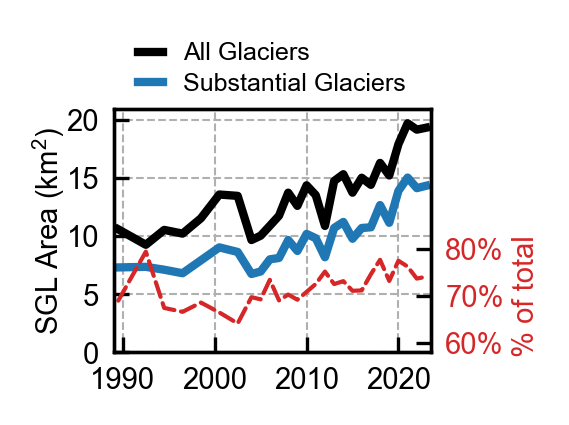

In [53]:
# plot time series of total sgl area across the region, and 128 substantial glaciers
df_sub = df_all_nlt[df_all_nlt['rgi_id'].isin(rgi_substantial)]

cs = plt.cm.Spectral(np.linspace(0, 1, 6))

# initiate figure
fig,ax = plt.subplots(figsize=(2,1.5), dpi=300)

# plot entire region total
sgl_areas = df_all_nlt[c_1yr].sum(axis=0).values
sgl_areas_sub = df_sub[c_1yr].sum(axis=0).values

# fill below the curve
# ax.fill_between(ys, sgl_areas/(1000*1000), color='lavender', alpha=0.6, zorder=2)
ax.plot( mids, sgl_areas/(1000*1000),
        label="All Glaciers", color='black', linewidth=2, zorder=2)
ax.plot( mids, sgl_areas_sub/(1000*1000),
        label="Substantial Glaciers", color='tab:blue', linewidth=2, zorder=2)

# twinx to show percentage
ax2 = ax.twinx()
ax2.plot( mids, sgl_areas_sub/sgl_areas*100, label="Percentage",
         color='tab:red', linestyle='dashed', dash_capstyle = 'round', linewidth=1, zorder=1)
ax2.set_ylim(58,110)
ax2.set_yticks([60,70,80], ['60%', '70%', '80%'], color='tab:red', fontsize=7)
ax2.set_ylabel('% of total                ', color='tab:red', labelpad=2, fontsize=7)

# ax.set_xlabel("Year", fontsize=8)
ax.set_ylabel("SGL Area (km$^2$)", labelpad=0, fontsize=7)
ax.set_ylim(0,21)
ax.set_xlim(1989,2023.5)
ax.set_xticks([1990, 2000, 2010, 2020],[1990, 2000, 2010, 2020], fontsize=7)
ax.set_yticks([0, 5, 10, 15, 20],[0, 5, 10, 15, 20], fontsize=7)

ax.tick_params(axis="both",direction="in")
ax2.tick_params(axis="both",direction="in")
ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)

ax.legend(framealpha=0, fontsize=6, loc="lower center", handlelength=1, borderpad=0.5,
          labelspacing=0.3,bbox_to_anchor=(0.5,0.95), edgecolor='black')
ax.set_facecolor('white')
plt.tight_layout()

# ax.text(0.07,0.85,'c.',transform=ax.transAxes, zorder=10, fontsize=8, fontweight='bold')

save=1
if save:
    plt.savefig(os.path.join(folder_HMA,'Figures','Substantial Glaciers',f'timeseries.png'),
                transparent=True, bbox_inches='tight', dpi=400)
